In [174]:
from analytics_utils.partial_autocorrelation import partial_autocorrelation
from analytics_utils.linear_regression import linear_regression
from analytics_utils.autocorrelation import autocorrelation
from analytics_utils.describe_data import describe_data
from statsmodels.tsa.seasonal import seasonal_decompose
from analytics_utils.interpolate import interpolate
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from analytics_utils.decomposers import seasonal
from analytics_utils.correlate import correlate
from statsmodels.tsa.stattools import adfuller
from analytics_utils.roll import roll
from analytics_utils.ewm import ewm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

---

## Global variables

In [2]:
ARGS = {
    "mucuri_h": "/home/ferraz/dev/my/prediction-wind-speed-mp/confidential/headers.csv",
    "mucuri_t": "/home/ferraz/dev/my/prediction-wind-speed-mp/confidential/train150.txt",
    "mucuri_p": "/home/ferraz/dev/my/prediction-wind-speed-mp/confidential/prev150.txt",
    "drups_df": "temp/bear_log.csv",
}

---

## Functions

### Third-party functions

In [51]:
# Third-party function (Lucas Alves)
def plot_distributions(dataset):
    dataset_columns = list(dataset.columns.values)
    plt_col_num = 2
    plt_row_num = len(dataset_columns)
    
    plt.figure(figsize=(15, plt_row_num*5))
    
    for index, label in enumerate(dataset_columns):
        # Subplot for histogram and KDE
        plt.subplot(plt_row_num, plt_col_num, (2*index)+1)
        
        # Plot histogram
        ax1 = sns.distplot(dataset.loc[:, label].dropna(), hist=True, kde=False)
        ax1.set_ylabel('Frequência')
        
        # Plot KDE (Kernel Density Estimation)
        ax2 = ax1.twinx()
        sns.distplot(dataset.loc[:, label].dropna(), hist=False, kde=True, ax=ax2)
        ax2.set_ylabel('Densidade de Probabilidade Estimada')

        # Computation of data statistics
        median = dataset.loc[:, label].median()
        quartile_1 = dataset.loc[:, label].quantile(q=0.25)
        quartile_3 = dataset.loc[:, label].quantile(q=0.75)
        min_val = dataset.loc[:, label].min()
        max_val = dataset.loc[:, label].max()
        inf_limit = max(min_val, (quartile_1 - (quartile_3-quartile_1)*1.5))
        sup_limit = min(max_val, (quartile_3 + (quartile_3-quartile_1)*1.5))
        
        # Computation of outliers
        inf_outliers = dataset.loc[dataset.loc[:, label]<inf_limit, :].shape[0]
        sup_outliers = dataset.loc[dataset.loc[:, label]>sup_limit, :].shape[0]
        inf_outliers_percent = (inf_outliers/dataset.loc[:, label].dropna().shape[0])
        sup_outliers_percent = (sup_outliers/dataset.loc[:, label].dropna().shape[0])
        
        # Plot lines indicating the statistics
        plt.axvline(x=median, linestyle='-', linewidth=1.3, color='black', label='Mediana')
        plt.axvline(x=quartile_1, linestyle='-', linewidth=1.3, color='green', label='1º Quartil')
        plt.axvline(x=quartile_3, linestyle='-', linewidth=1.3, color='green', label='3º Quartil')
        plt.axvline(x=inf_limit, linestyle='-', linewidth=1.3, color='red',
                    label='Limite inferior\n{:.2%} dos dados abaixo'.format(inf_outliers_percent))
        plt.axvline(x=sup_limit, linestyle='-', linewidth=1.3, color='red',
                    label='Limite superior\n{:.2%} dos dados acima'.format(sup_outliers_percent))
        plt.legend()
        
        # Plot boxplot in other subplot
        plt.subplot(plt_row_num, plt_col_num, (2*index)+2)
        dataset.boxplot(column=label)
        plt.ylabel('Valores')
        plt.title('')
        plt.grid(True)
        
    plt.subplots_adjust(wspace=0.35, hspace=0.3)
    plt.show()

---

### Others functions

In [101]:
#Perform Dickey-Fuller test:
def _dftest(df):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(
        dftest[0:4],
        index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    )
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

---

### Plot functions

In [105]:
# Function for lineplot chart (described datas)
def _describe_lineplot(df, describe, measures, xlabel='time'):
    for column in df:
        
        # Copy dataframe and insert {measures}
        df_aux = df[[column]].copy()
        for measure in measures:
            df_aux[f"{measure}"] = describe.loc[column, measure]

        # Pre calculate
        _max = df_aux[column].max()
        _min = df_aux[column].min()
        q1 = describe.loc[column, "1-quartil"]
        q3 = describe.loc[column, "3-quartil"]
        irq = q3 - q1

        # Calculate lower and upper limit
        df_aux["limite_superior"] = min(_max, q3+(1.5*irq))
        df_aux["limite_inferior"] = max(_min, q1-(1.5*irq))

        # Plot df
        _, ax1 = plt.subplots(1, 1, figsize=(15, 5))
        ax = sns.lineplot(data=df_aux, ax=ax1)
        ax.set(xlabel=xlabel, ylabel=column)

In [106]:
# Function for multline plot
def _mplot(df, xlabel='time'):
    for column in df:
        _, ax1 = plt.subplots(1, 1, figsize=(15, 5))
        ax = sns.lineplot(data=df[[column]], ax=ax1)
        ax.set(xlabel=xlabel, ylabel=column)

In [109]:
# Function for plot acf autocorrelate
def _acfplot(df, lags=12):
    for column in df:
        ax = plot_acf(
            df[[column]],
            lags=lags,
            title=f'{column} - Autocorrelation',
        )
        ax.set_size_inches(15,5)

In [108]:
# Function for plot acf autocorrelate
def _pacfplot(df, lags=12):
    for column in df:
        ax = plot_pacf(
            df[[column]],
            lags=lags,
            title=f'{column} - Partial Autocorrelation'
        )
        ax.set_size_inches(15,5)

In [98]:
# Function for plot heatmap
def _heatmap(df):
    corr = correlate(df_inter)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        _, ax1 = plt.subplots(1, 1, figsize=(15, 5))
        ax = sns.heatmap(
            corr,
            mask=mask,
            vmin=-1,
            vmax=1,
            annot=True,
            cmap='coolwarm',
            square=True,
            linewidths=.5,
            ax=ax1,
        )

In [149]:
# Function for plot evolution chart with rolling and adftest
def _rollplot(df, xlabel='time'):
    # Determing rolling statistics
    rolmean = roll(df, 12, roll_type="mean")
    rolstd = roll(df, 12, roll_type="std")

    # Calculate moving mean and moving std
    for column in df:
        df_aux = pd.concat(
            [
                df[[column]],
                rolmean[column].rename("média móvel"),
                rolstd[column].rename("desvio médio")
            ],
            axis=1
        )

        # Plot df
        _, ax1 = plt.subplots(1, 1, figsize=(15, 5))
        ax = sns.lineplot(data=df_aux, ax=ax1)
        ax.set(xlabel=xlabel, ylabel=column)
        plt.show(block=False)
    
        #Perform Dickey-Fuller test:
        _dftest(df_aux[column])

In [230]:
# Function for plot seasonal decompose
def _seasonalplot(df, model='additive'):
    for column in df:
        ax = seasonal_decompose(
            df[column], freq=12, model=model
        ).plot()
        ax.set_size_inches(15,5)
        plt.xlabel(column)

---

## Mucuri Analysis

### Load and show datas

In [4]:
# Load dataset
headers = pd.read_csv(ARGS['mucuri_h'], header=None).iloc[0]
_t = pd.read_csv(ARGS['mucuri_t'], delimiter='\t', header=None, names=headers)
_p = pd.read_csv(ARGS['mucuri_p'], delimiter='\t', header=None, names=headers)
df_m = pd.concat([_t, _p], ignore_index=True)
df_m

Dia  Mês   Ano  Hora  Velocidade    Direção  Temperatura    Umidade  \
0     30   11  2015    14   13.012139  75.105481    27.516129  72.930636   
1     30   11  2015    15   12.726087  68.334332    27.238095  75.212121   
2     30   11  2015    16   12.081111  64.457865    27.105263  75.741379   
3     30   11  2015    17   11.647222  53.842100    26.305556  75.302632   
4     30   11  2015    18   11.064444  53.945279    25.464286  76.592593   
..   ...  ...   ...   ...         ...        ...          ...        ...   
739   31   12  2015     9    7.370556  88.967009    25.545455  90.612500   
740   31   12  2015    10   10.400556  89.474475    23.558442  91.142857   
741   31   12  2015    11   12.400556  89.119129    23.369863  90.567376   
742   31   12  2015    12   13.944444  85.945816    23.240741  88.645833   
743   31   12  2015    13   14.821111  82.373032    23.875000  87.005556   

         Pressão  
0    1020.422601  
1    1020.394348  
2    1020.508333  
3    1020.611000  
4    1020.866500  
..           ...  
739  1018.871167  
740  1018.303667  
741  1017.004667  
742  1016.574167  
743  1016.205167  

[744 rows x 9 columns]

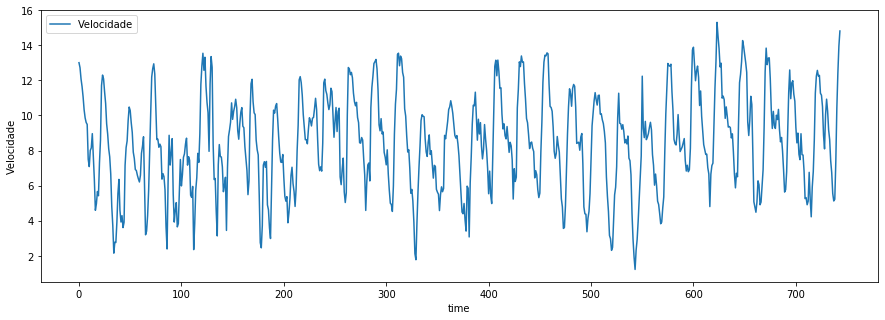

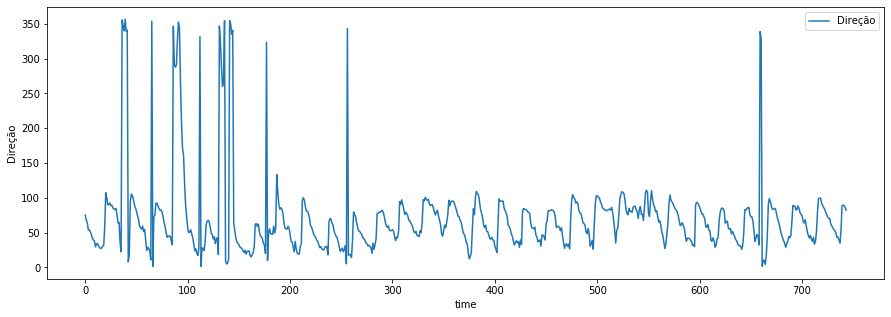

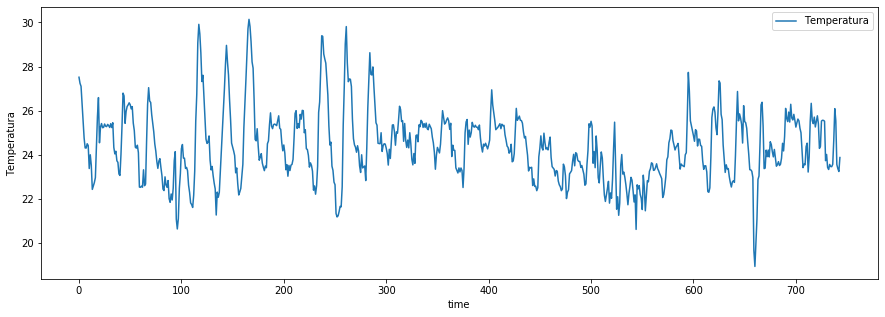

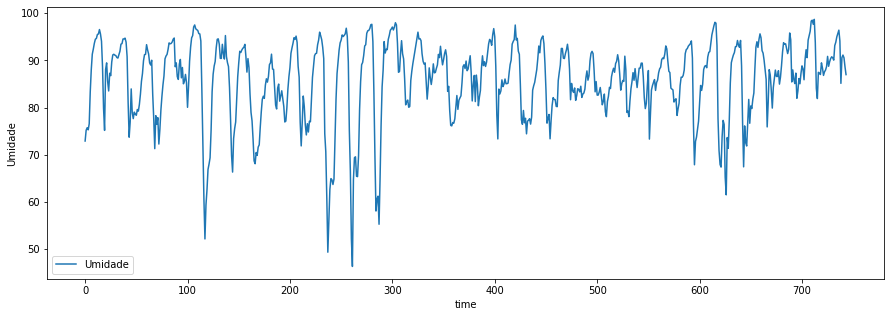

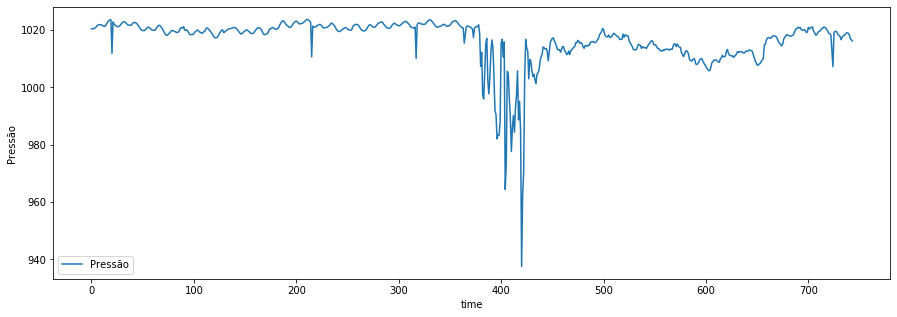

In [120]:
# Show evolution chart
_mplot(df_m.loc[:, "Velocidade":])

---

### Preprocessing (nan values)

In [6]:
describe_data(df_m)

max          min        média      mediana    1-quartil  \
cabeçalho                                                                      
Dia            31.000000     1.000000    15.986559    16.000000     8.000000   
Mês            12.000000    11.000000    11.986559    12.000000    12.000000   
Ano          2015.000000  2015.000000  2015.000000  2015.000000  2015.000000   
Hora           23.000000     0.000000    11.500000    11.500000     5.750000   
Velocidade     15.313889     1.211905     8.440594     8.489167     6.498889   
Direção       356.553715     1.448179    70.913340    59.891964    39.725962   
Temperatura    30.140625    18.936170    24.391007    24.310811    23.354245   
Umidade        98.710843    46.355556    85.680048    87.350906    81.606481   
Pressão      1023.726500   937.534333  1016.543352  1019.163250  1014.022208   

               3-quartil    variância  desvio padrão  desvio absoluto  \
cabeçalho                                                               
Dia            24.000000    79.717181       8.928448         7.728928   
Mês            12.000000     0.013278       0.115230         0.026520   
Ano          2015.000000     0.000000       0.000000         0.000000   
Hora           17.250000    47.981157       6.926843         6.000000   
Velocidade     10.404306     7.586714       2.754399         2.245532   
Direção        83.353583  3464.189743      58.857368        32.925486   
Temperatura    25.373400     2.538095       1.593140         1.231791   
Umidade        91.520952    68.308641       8.264904         6.349837   
Pressão      1021.024417    63.461228       7.966256         5.070307   

              amplitude          rms    curtose  assimetria  contagem  NaNs  
cabeçalho                                                                    
Dia           30.000000    18.307925  -1.210866   -0.007436       744     0  
Mês            1.000000    11.987112  69.890489   -8.467740       744     0  
Ano            0.000000  2015.000000   0.000000    0.000000       744     0  
Hora          23.000000    13.422618  -1.204198    0.000000       744     0  
Velocidade    14.101984     8.878071  -0.583534   -0.064374       744     0  
Direção      355.105536    92.131620  12.907184    3.402864       744     0  
Temperatura   11.204455          NaN   1.074509    0.538121       743     1  
Umidade       52.355288    86.077218   2.108927   -1.237156       744     0  
Pressão       86.192167  1016.574524  23.052438   -3.844125       744     0

---

### Interpolation or dropna

In [7]:
# Linear interpolation
inter_l = interpolate(df_m, method='linear')
inter_l

Dia  Mês   Ano  Hora  Velocidade    Direção  Temperatura    Umidade  \
0     30   11  2015    14   13.012139  75.105481    27.516129  72.930636   
1     30   11  2015    15   12.726087  68.334332    27.238095  75.212121   
2     30   11  2015    16   12.081111  64.457865    27.105263  75.741379   
3     30   11  2015    17   11.647222  53.842100    26.305556  75.302632   
4     30   11  2015    18   11.064444  53.945279    25.464286  76.592593   
..   ...  ...   ...   ...         ...        ...          ...        ...   
739   31   12  2015     9    7.370556  88.967009    25.545455  90.612500   
740   31   12  2015    10   10.400556  89.474475    23.558442  91.142857   
741   31   12  2015    11   12.400556  89.119129    23.369863  90.567376   
742   31   12  2015    12   13.944444  85.945816    23.240741  88.645833   
743   31   12  2015    13   14.821111  82.373032    23.875000  87.005556   

         Pressão  
0    1020.422601  
1    1020.394348  
2    1020.508333  
3    1020.611000  
4    1020.866500  
..           ...  
739  1018.871167  
740  1018.303667  
741  1017.004667  
742  1016.574167  
743  1016.205167  

[744 rows x 9 columns]

In [8]:
# Cubic interpolation
inter_c = interpolate(df_m, method="cubic")
inter_c

Dia  Mês   Ano  Hora  Velocidade    Direção  Temperatura    Umidade  \
0     30   11  2015    14   13.012139  75.105481    27.516129  72.930636   
1     30   11  2015    15   12.726087  68.334332    27.238095  75.212121   
2     30   11  2015    16   12.081111  64.457865    27.105263  75.741379   
3     30   11  2015    17   11.647222  53.842100    26.305556  75.302632   
4     30   11  2015    18   11.064444  53.945279    25.464286  76.592593   
..   ...  ...   ...   ...         ...        ...          ...        ...   
739   31   12  2015     9    7.370556  88.967009    25.545455  90.612500   
740   31   12  2015    10   10.400556  89.474475    23.558442  91.142857   
741   31   12  2015    11   12.400556  89.119129    23.369863  90.567376   
742   31   12  2015    12   13.944444  85.945816    23.240741  88.645833   
743   31   12  2015    13   14.821111  82.373032    23.875000  87.005556   

         Pressão  
0    1020.422601  
1    1020.394348  
2    1020.508333  
3    1020.611000  
4    1020.866500  
..           ...  
739  1018.871167  
740  1018.303667  
741  1017.004667  
742  1016.574167  
743  1016.205167  

[744 rows x 9 columns]

In [22]:
# Drop nan
dropna_m = df_m.dropna()
dropna_m

Dia  Mês   Ano  Hora  Velocidade    Direção  Temperatura    Umidade  \
0     30   11  2015    14   13.012139  75.105481    27.516129  72.930636   
1     30   11  2015    15   12.726087  68.334332    27.238095  75.212121   
2     30   11  2015    16   12.081111  64.457865    27.105263  75.741379   
3     30   11  2015    17   11.647222  53.842100    26.305556  75.302632   
4     30   11  2015    18   11.064444  53.945279    25.464286  76.592593   
..   ...  ...   ...   ...         ...        ...          ...        ...   
739   31   12  2015     9    7.370556  88.967009    25.545455  90.612500   
740   31   12  2015    10   10.400556  89.474475    23.558442  91.142857   
741   31   12  2015    11   12.400556  89.119129    23.369863  90.567376   
742   31   12  2015    12   13.944444  85.945816    23.240741  88.645833   
743   31   12  2015    13   14.821111  82.373032    23.875000  87.005556   

         Pressão  
0    1020.422601  
1    1020.394348  
2    1020.508333  
3    1020.611000  
4    1020.866500  
..           ...  
739  1018.871167  
740  1018.303667  
741  1017.004667  
742  1016.574167  
743  1016.205167  

[743 rows x 9 columns]

In [38]:
# Choose linear, cubic interpolation or dropna for next steps
df_inter = inter_c

---

### Describe datas

In [10]:
# Datas description
describe_m = describe_data(df_inter)
describe_m

max          min        média      mediana    1-quartil  \
cabeçalho                                                                      
Dia            31.000000     1.000000    15.986559    16.000000     8.000000   
Mês            12.000000    11.000000    11.986559    12.000000    12.000000   
Ano          2015.000000  2015.000000  2015.000000  2015.000000  2015.000000   
Hora           23.000000     0.000000    11.500000    11.500000     5.750000   
Velocidade     15.313889     1.211905     8.440594     8.489167     6.498889   
Direção       356.553715     1.448179    70.913340    59.891964    39.725962   
Temperatura    30.140625    18.936170    24.390728    24.309817    23.356368   
Umidade        98.710843    46.355556    85.680048    87.350906    81.606481   
Pressão      1023.726500   937.534333  1016.543352  1019.163250  1014.022208   

               3-quartil    variância  desvio padrão  desvio absoluto  \
cabeçalho                                                               
Dia            24.000000    79.717181       8.928448         7.728928   
Mês            12.000000     0.013278       0.115230         0.026520   
Ano          2015.000000     0.000000       0.000000         0.000000   
Hora           17.250000    47.981157       6.926843         6.000000   
Velocidade     10.404306     7.586714       2.754399         2.245532   
Direção        83.353583  3464.189743      58.857368        32.925486   
Temperatura    25.370910     2.534736       1.592086         1.230401   
Umidade        91.520952    68.308641       8.264904         6.349837   
Pressão      1021.024417    63.461228       7.966256         5.070307   

              amplitude          rms    curtose  assimetria  contagem  NaNs  
cabeçalho                                                                    
Dia           30.000000    18.307925  -1.210866   -0.007436       744     0  
Mês            1.000000    11.987112  69.890489   -8.467740       744     0  
Ano            0.000000  2015.000000   0.000000    0.000000       744     0  
Hora          23.000000    13.422618  -1.204198    0.000000       744     0  
Velocidade    14.101984     8.878071  -0.583534   -0.064374       744     0  
Direção      355.105536    92.131620  12.907184    3.402864       744     0  
Temperatura   11.204455    24.442564   1.080181    0.538987       744     0  
Umidade       52.355288    86.077218   2.108927   -1.237156       744     0  
Pressão       86.192167  1016.574524  23.052438   -3.844125       744     0

---

### Show datas chart with your descriptions

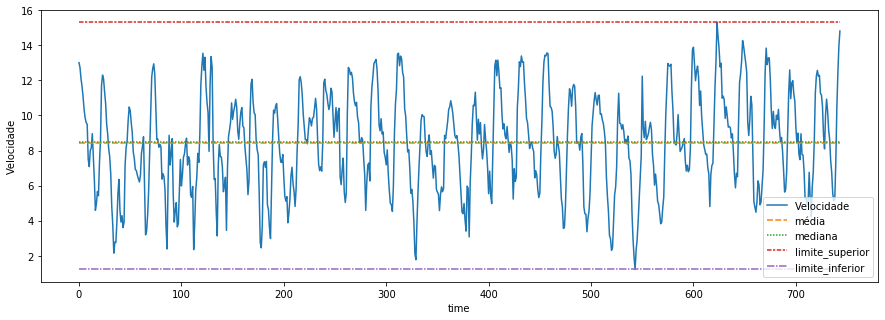

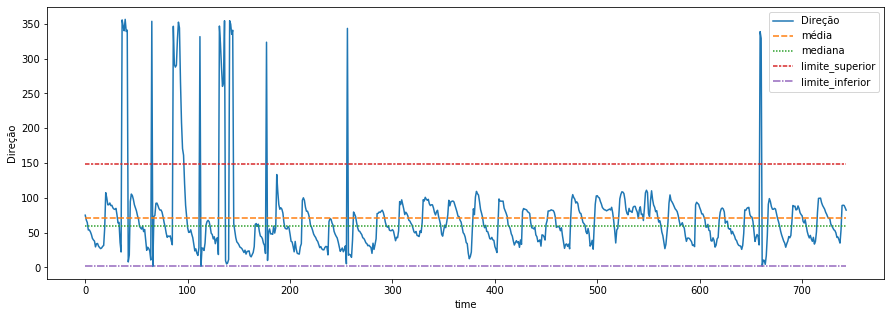

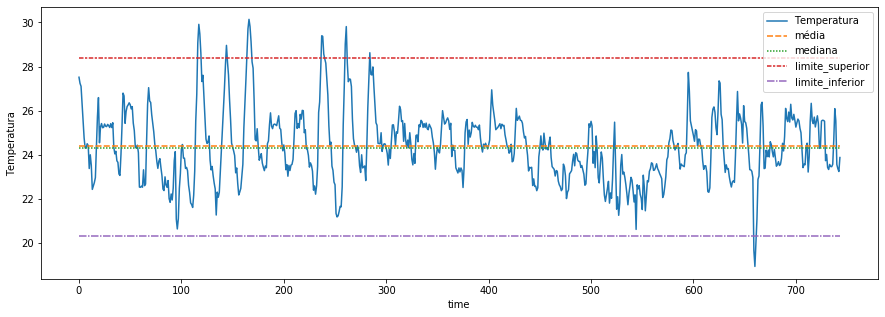

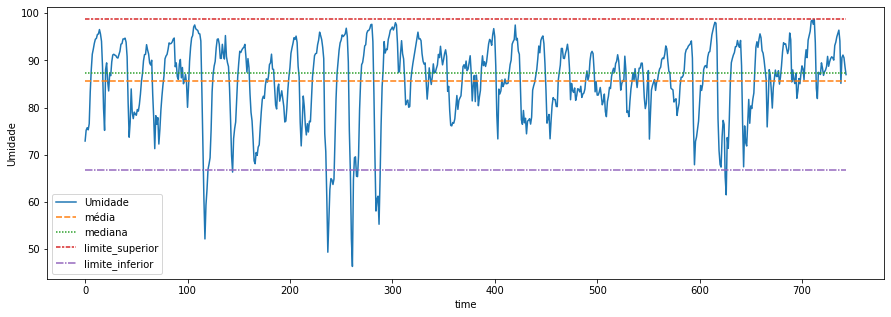

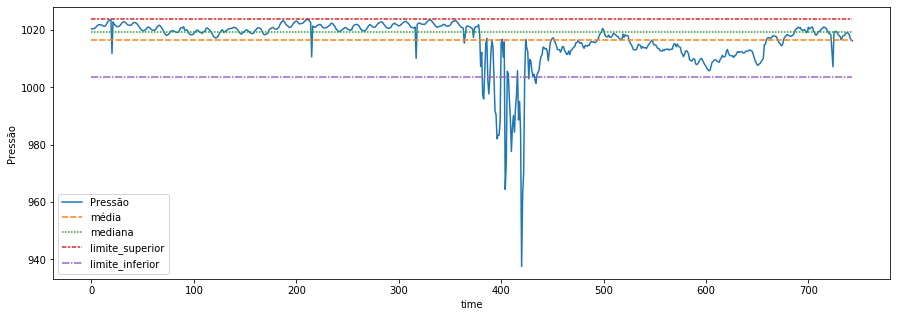

In [121]:
# Show descriptions chart
_describe_lineplot(
    df_inter.loc[:,"Velocidade":],
    describe_m,
    ["média", "mediana"]
)

---

### Boxplot and Probability density function

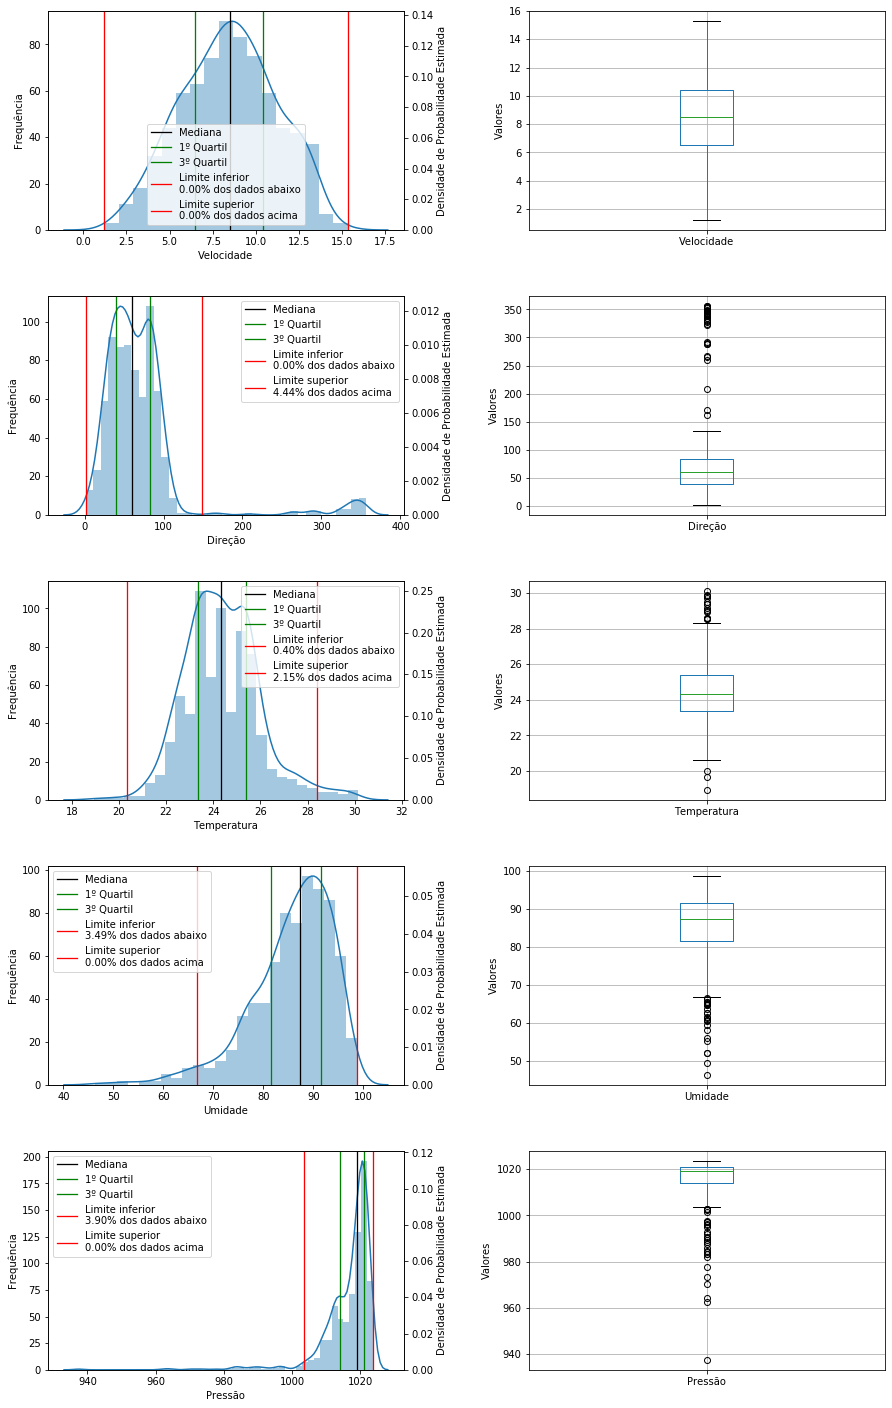

In [44]:
plot_distributions(df_inter.loc[:, "Velocidade":])

---

### Autocorrelate

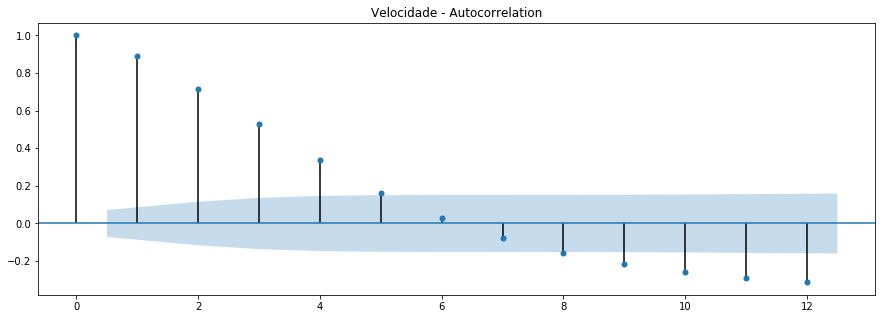

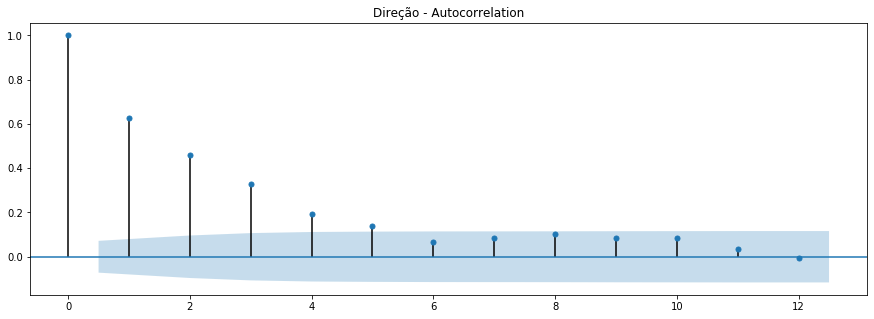

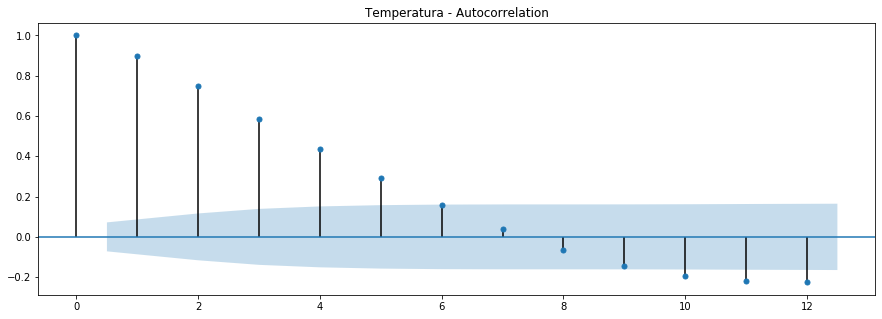

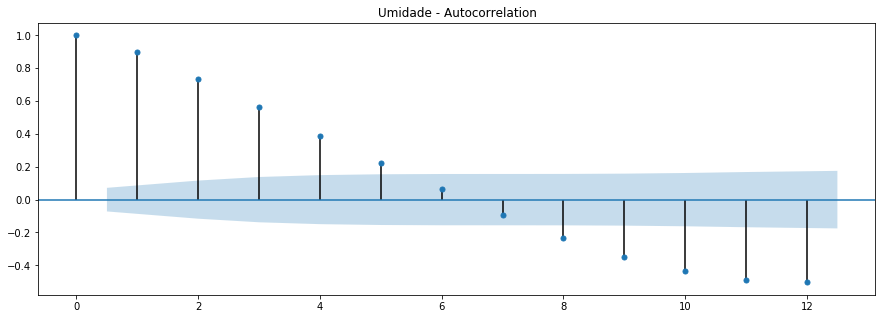

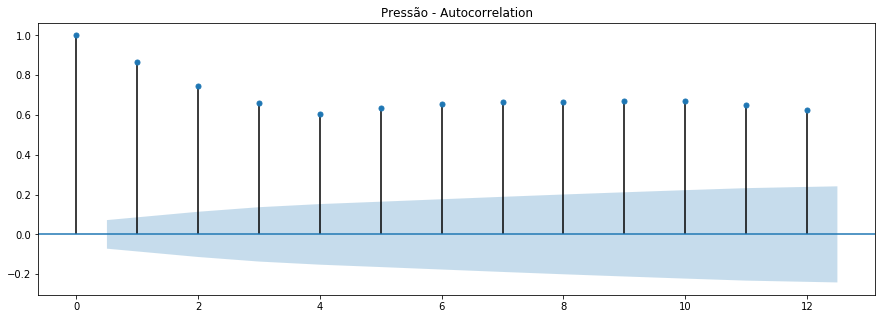

In [73]:
# Plot acf autocorrelate
_acfplot(df_inter.loc[:, "Velocidade":])

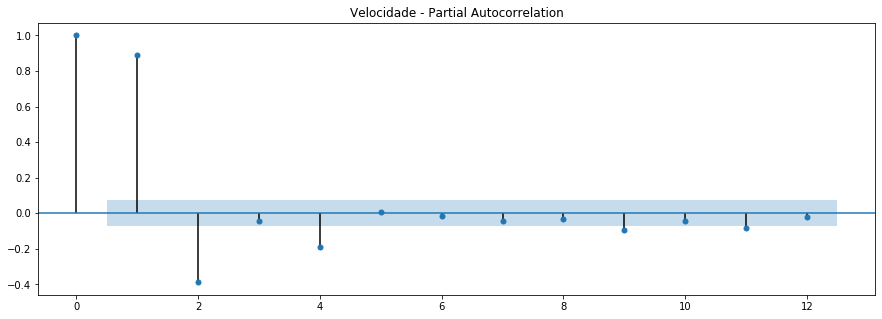

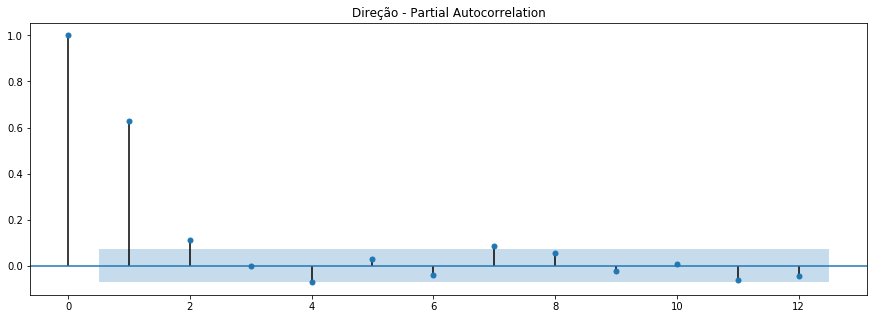

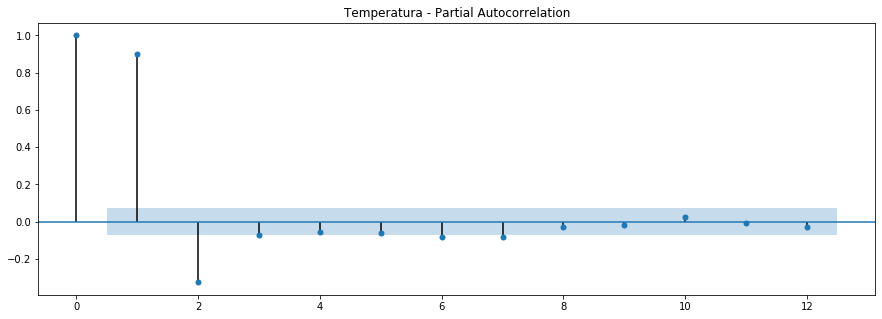

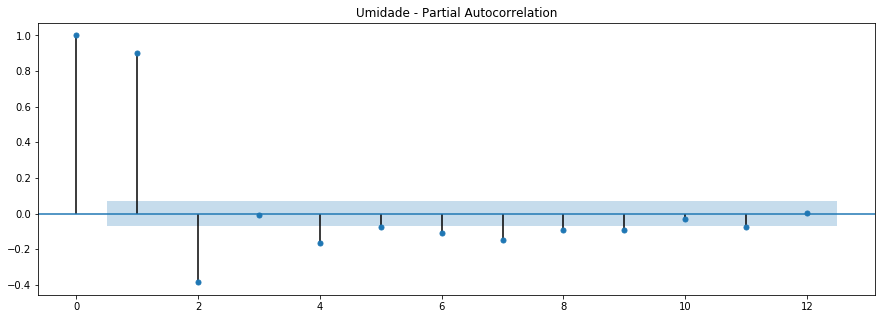

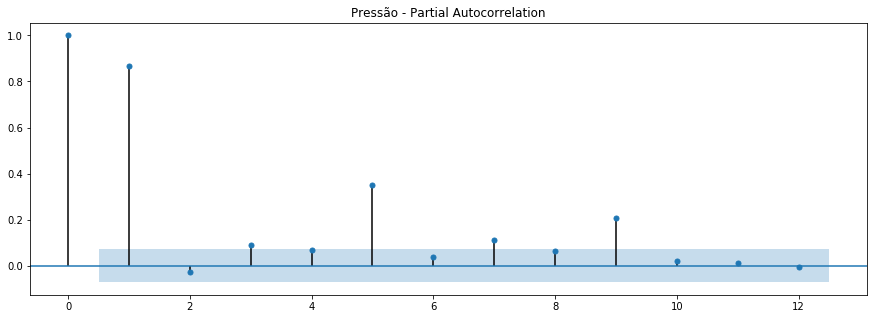

In [74]:
# Plot pacf autocorrelate
_pacfplot(df_inter.loc[:, "Velocidade":])

---

### Correlate

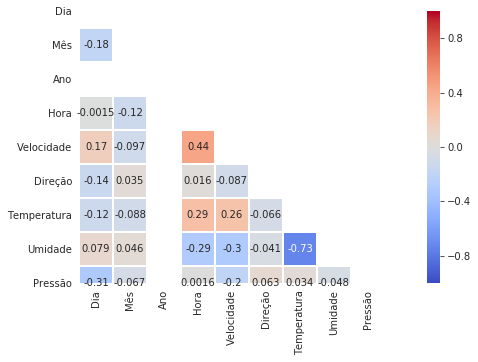

In [134]:
# Show correlation matrix    
_heatmap(df_inter)

---

### Stationarity test

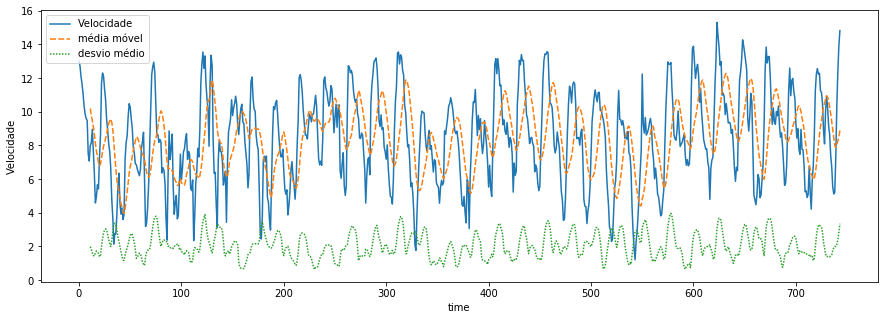

Results of Dickey-Fuller Test:
Test Statistic                  -3.087300
p-value                          0.027507
#Lags Used                      20.000000
Number of Observations Used    723.000000
Critical Value (1%)             -3.439427
Critical Value (5%)             -2.865546
Critical Value (10%)            -2.568903
dtype: float64


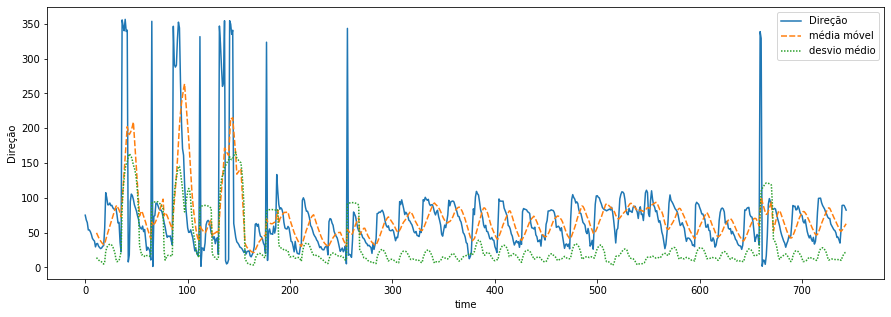

Results of Dickey-Fuller Test:
Test Statistic                -7.008247e+00
p-value                        7.030321e-10
#Lags Used                     7.000000e+00
Number of Observations Used    7.360000e+02
Critical Value (1%)           -3.439266e+00
Critical Value (5%)           -2.865475e+00
Critical Value (10%)          -2.568865e+00
dtype: float64


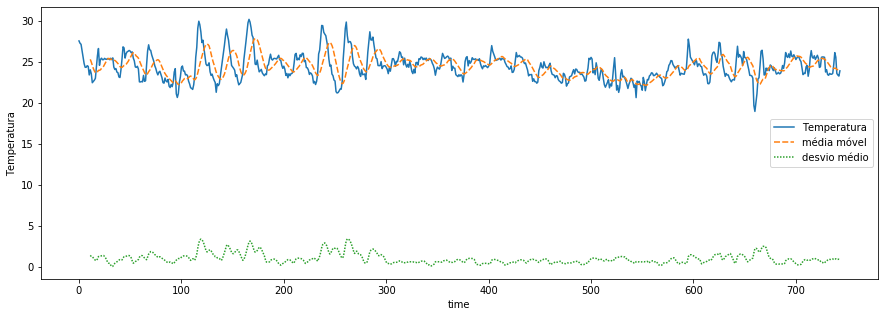

Results of Dickey-Fuller Test:
Test Statistic                  -2.955899
p-value                          0.039223
#Lags Used                      20.000000
Number of Observations Used    723.000000
Critical Value (1%)             -3.439427
Critical Value (5%)             -2.865546
Critical Value (10%)            -2.568903
dtype: float64


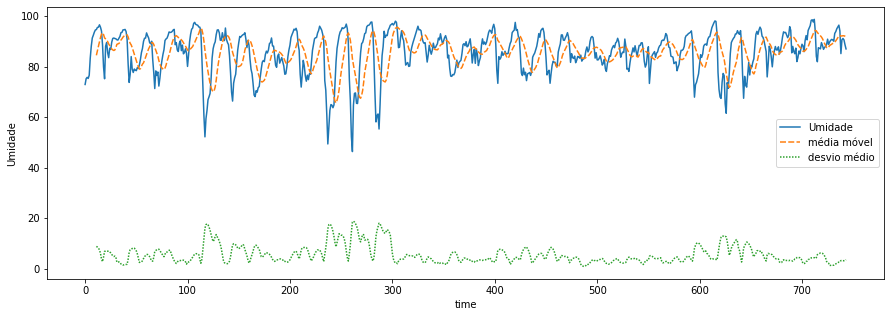

Results of Dickey-Fuller Test:
Test Statistic                  -3.947483
p-value                          0.001712
#Lags Used                      20.000000
Number of Observations Used    723.000000
Critical Value (1%)             -3.439427
Critical Value (5%)             -2.865546
Critical Value (10%)            -2.568903
dtype: float64


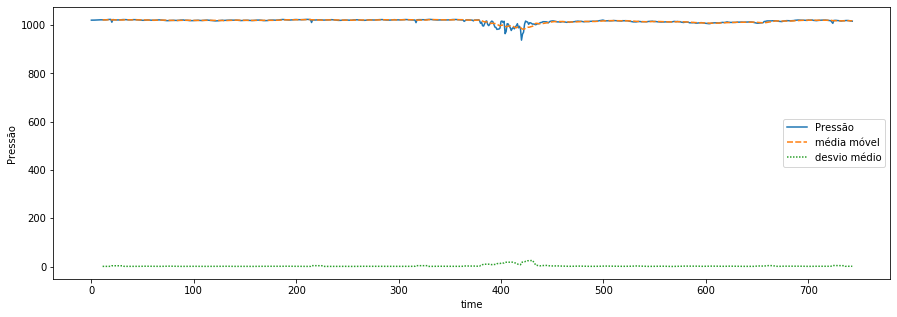

Results of Dickey-Fuller Test:
Test Statistic                  -2.592028
p-value                          0.094656
#Lags Used                      20.000000
Number of Observations Used    723.000000
Critical Value (1%)             -3.439427
Critical Value (5%)             -2.865546
Critical Value (10%)            -2.568903
dtype: float64


In [148]:
# Plot evolution with moving (mean, std) and adftest
_rollplot(df_inter.loc[:,"Velocidade":])

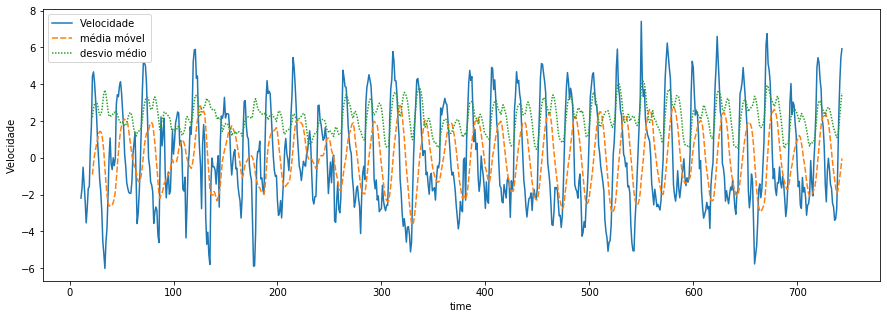

Results of Dickey-Fuller Test:
Test Statistic                -7.552953e+00
p-value                        3.153381e-11
#Lags Used                     2.000000e+01
Number of Observations Used    7.120000e+02
Critical Value (1%)           -3.439568e+00
Critical Value (5%)           -2.865608e+00
Critical Value (10%)          -2.568936e+00
dtype: float64


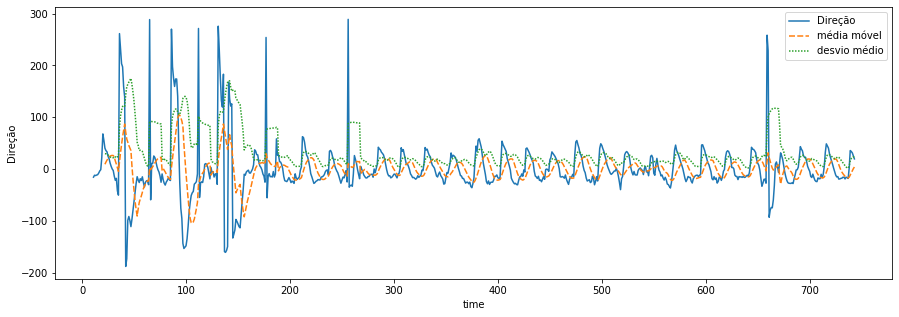

Results of Dickey-Fuller Test:
Test Statistic                -9.595371e+00
p-value                        1.984922e-16
#Lags Used                     1.300000e+01
Number of Observations Used    7.190000e+02
Critical Value (1%)           -3.439478e+00
Critical Value (5%)           -2.865568e+00
Critical Value (10%)          -2.568915e+00
dtype: float64


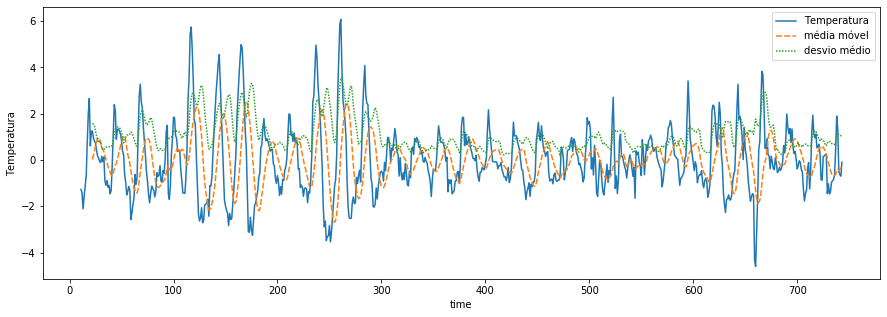

Results of Dickey-Fuller Test:
Test Statistic                -7.508138e+00
p-value                        4.082664e-11
#Lags Used                     2.000000e+01
Number of Observations Used    7.120000e+02
Critical Value (1%)           -3.439568e+00
Critical Value (5%)           -2.865608e+00
Critical Value (10%)          -2.568936e+00
dtype: float64


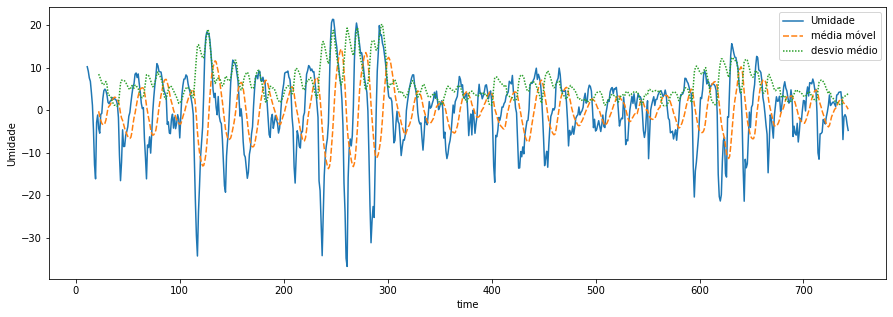

Results of Dickey-Fuller Test:
Test Statistic                -1.242121e+01
p-value                        4.133172e-23
#Lags Used                     1.700000e+01
Number of Observations Used    7.150000e+02
Critical Value (1%)           -3.439529e+00
Critical Value (5%)           -2.865591e+00
Critical Value (10%)          -2.568927e+00
dtype: float64


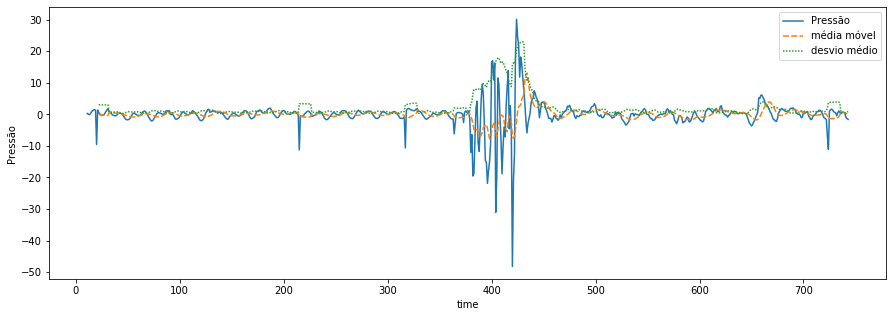

Results of Dickey-Fuller Test:
Test Statistic                  -4.848581
p-value                          0.000044
#Lags Used                      20.000000
Number of Observations Used    712.000000
Critical Value (1%)             -3.439568
Critical Value (5%)             -2.865608
Critical Value (10%)            -2.568936
dtype: float64


In [171]:
# Plot evolution with moving (mean, std) and adftest
# (Normalized with moving mean)
rolls = roll(df_inter.loc[:, "Velocidade":], 12)
df_normalize = pd.concat(
    [df_inter[[_]] - rolls[[_]] for _ in df_inter.loc[:, "Velocidade":]],
    axis=1,
)
_rollplot(df_normalize.dropna())

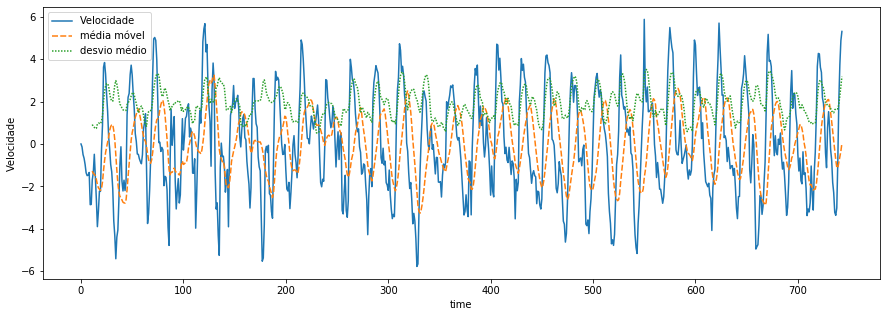

Results of Dickey-Fuller Test:
Test Statistic                -5.663875e+00
p-value                        9.246691e-07
#Lags Used                     2.000000e+01
Number of Observations Used    7.230000e+02
Critical Value (1%)           -3.439427e+00
Critical Value (5%)           -2.865546e+00
Critical Value (10%)          -2.568903e+00
dtype: float64


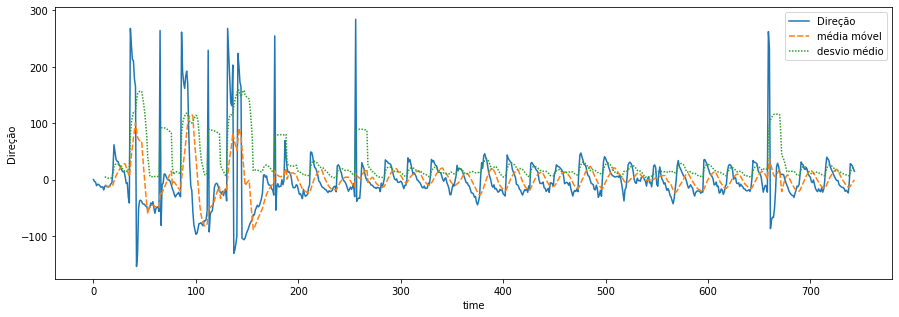

Results of Dickey-Fuller Test:
Test Statistic                -9.189934e+00
p-value                        2.136853e-15
#Lags Used                     6.000000e+00
Number of Observations Used    7.370000e+02
Critical Value (1%)           -3.439254e+00
Critical Value (5%)           -2.865470e+00
Critical Value (10%)          -2.568863e+00
dtype: float64


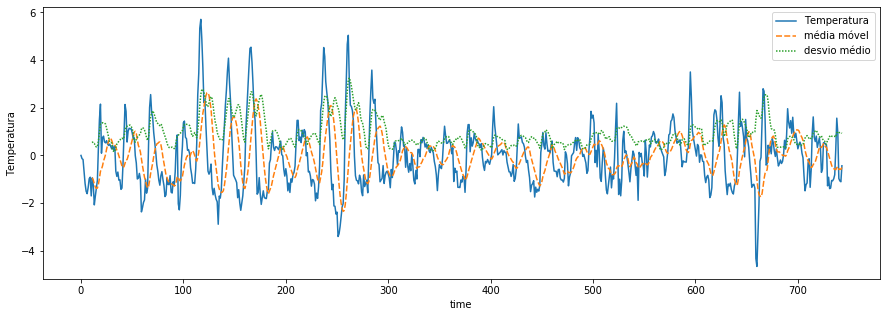

Results of Dickey-Fuller Test:
Test Statistic                -5.729319e+00
p-value                        6.656921e-07
#Lags Used                     2.000000e+01
Number of Observations Used    7.230000e+02
Critical Value (1%)           -3.439427e+00
Critical Value (5%)           -2.865546e+00
Critical Value (10%)          -2.568903e+00
dtype: float64


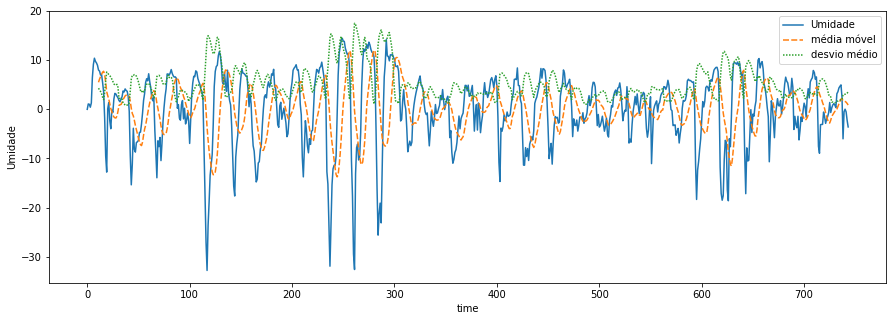

Results of Dickey-Fuller Test:
Test Statistic                -6.921496e+00
p-value                        1.143394e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.230000e+02
Critical Value (1%)           -3.439427e+00
Critical Value (5%)           -2.865546e+00
Critical Value (10%)          -2.568903e+00
dtype: float64


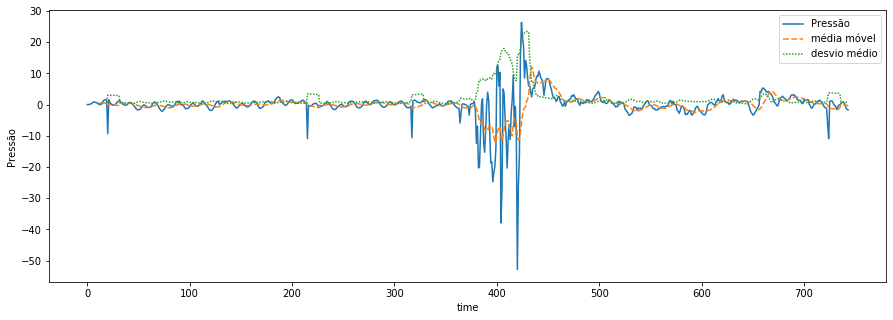

Results of Dickey-Fuller Test:
Test Statistic                  -4.001252
p-value                          0.001404
#Lags Used                      20.000000
Number of Observations Used    723.000000
Critical Value (1%)             -3.439427
Critical Value (5%)             -2.865546
Critical Value (10%)            -2.568903
dtype: float64


In [173]:
# Plot evolution with moving (mean, std) and adftest
# (Normalized with moving mean exponential weighted)
ewms = ewm(df_inter.loc[:, "Velocidade":], 12)
df_normalize = pd.concat(
    [df_inter[[_]] - ewms[[_]] for _ in df_inter.loc[:, "Velocidade":]],
    axis=1,
)
_rollplot(df_normalize.dropna())

---

### Decompositions

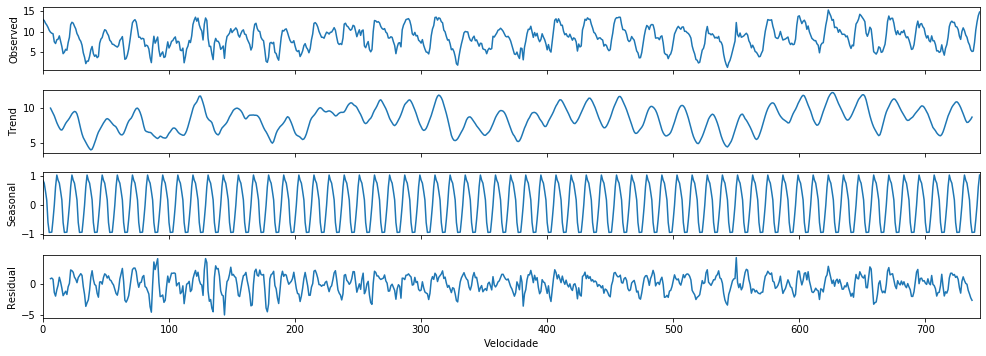

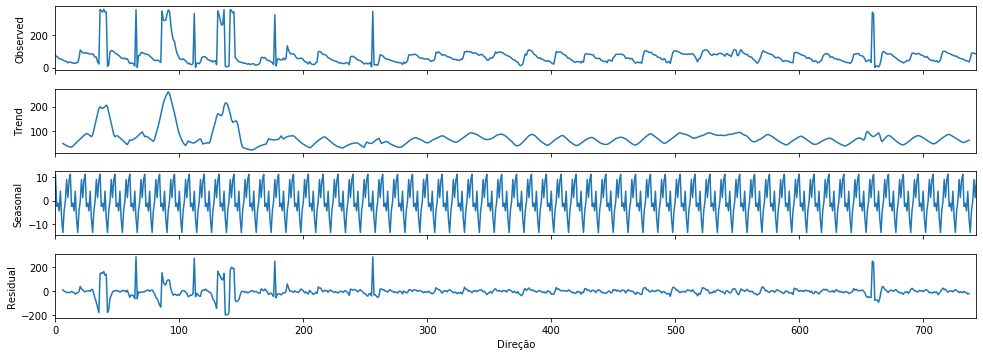

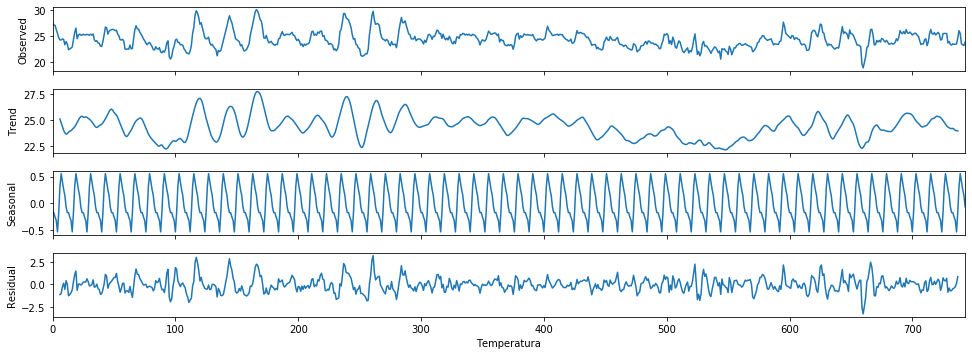

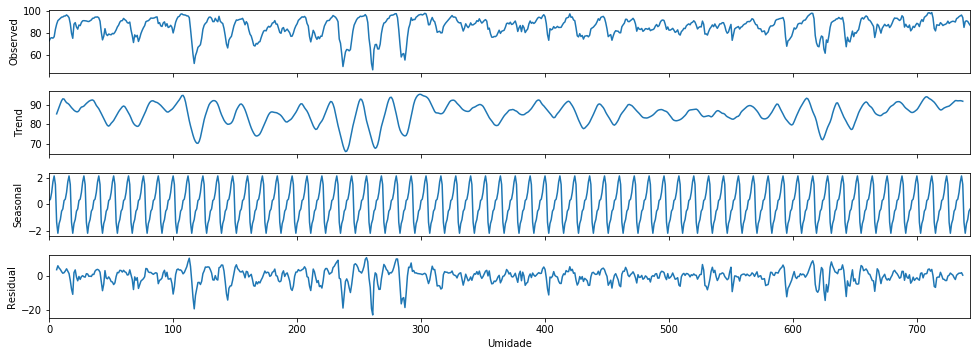

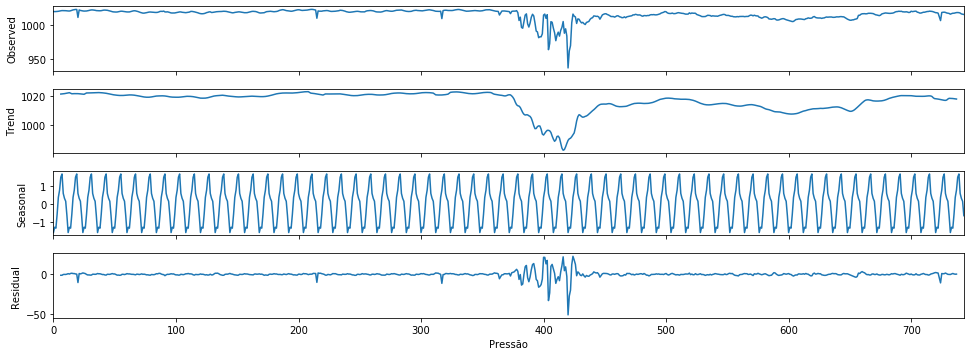

In [231]:
# Plot seasonal decompose
_seasonalplot(df_inter.loc[:, "Velocidade":])

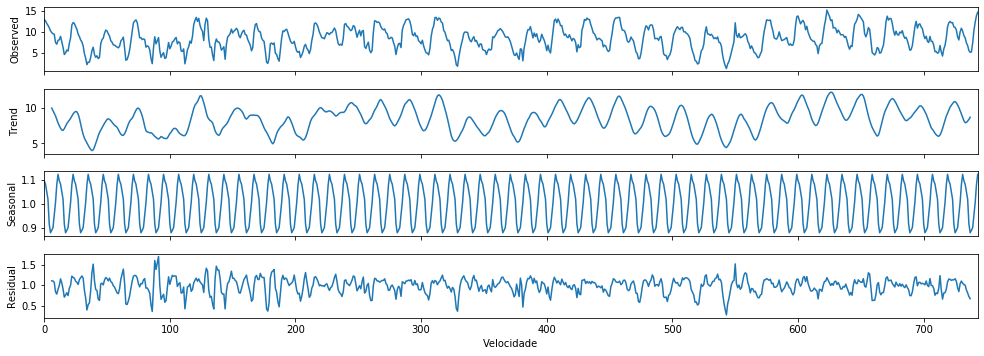

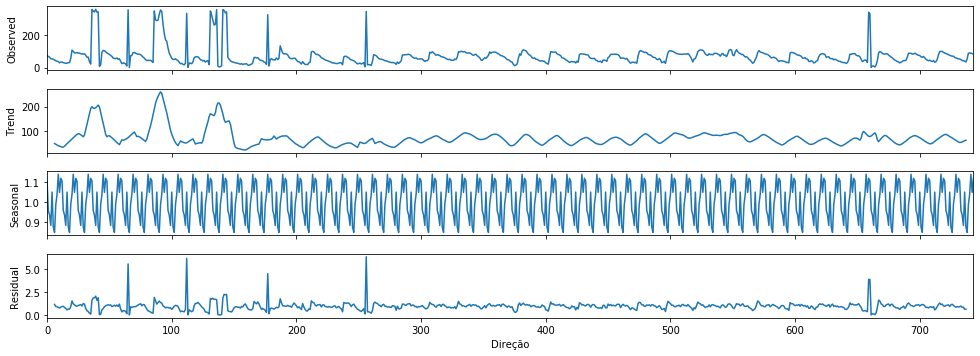

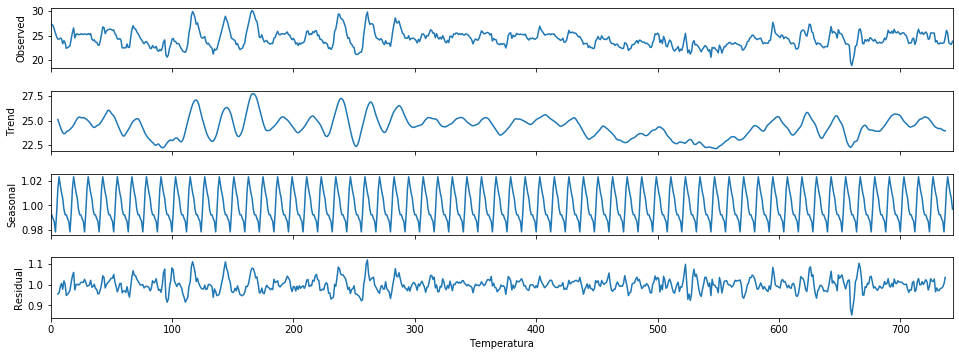

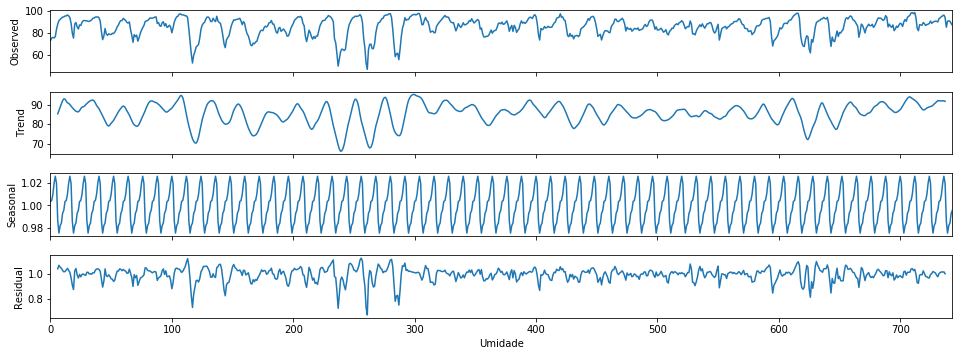

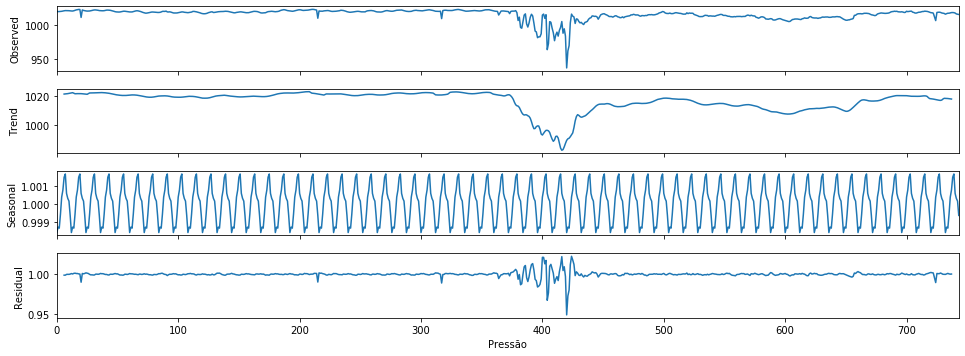

In [232]:
# Plot seasonal decompose
_seasonalplot(df_inter.loc[:, "Velocidade":], model='multiplicative')

---

## linear_regression

def linear_regression(
    data_frame: pd.DataFrame,
    fit_intercept: bool = True,
    normalize: bool = False,
    copy_X: bool = True,
    n_jobs: int = None,
    offset: int = 1,
    regressors: [str] = None,
    predictors: [str] = None,
) -> pd.DataFrame

In [ ]:
regress = linear_regression(df, regressors=["T_room"], predictors=["T_room"])
regress

In [ ]:
sns.lineplot(data=regress)

In [ ]:
sns.lineplot(data=df.loc[:,"T_room"])

---

## Drups Analysis

In [ ]:
# df = pd.read_csv('', parse_dates={'datetime': ['date', 'time']}, index_col='datetime').iloc[:1000,2:]
# df = pd.read_csv('temp/repsol.csv', parse_dates=['data'], index_col='data')[:1000]